# Final Project: Hubble Ultra Deep Field

#### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits #using astropy instead of fitsio!!!
import sep

#### Load image using astropy.io.fits

In [2]:
f105w=fits.getdata('hubble_f105w.fits')

### Plot the image using matplotlib

Text(0.5, 1.0, 'FITS Image')

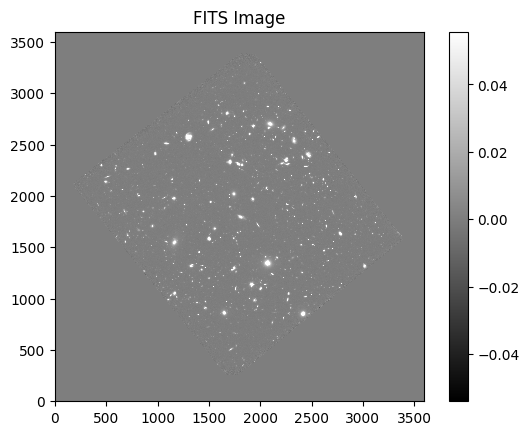

In [3]:
m, s = np.mean(f105w), np.std(f105w)
plt.imshow(f105w, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.title("FITS Image")

In [52]:
#check the byte order of OG data:
print(f105w.dtype)
print(f105w.strides)

#byte order to native byte order
if f105w.dtype.byteorder != 'native':
    f105w = f105w.byteswap().newbyteorder()

f105w = f105w.astype('float32')

float32
(14400, 4)


### Background Subtraction

In [53]:
bkg = sep.Background(f105w)

In [51]:
#get global mean and noise of image background:
print(bkg.globalback)
print(bkg.globalrms)

-4.1619141562191124e-32
4.4535624965647e-08


In [6]:
#evaluate background as 2-d array(size of OG image)
bkg_image = bkg.back()

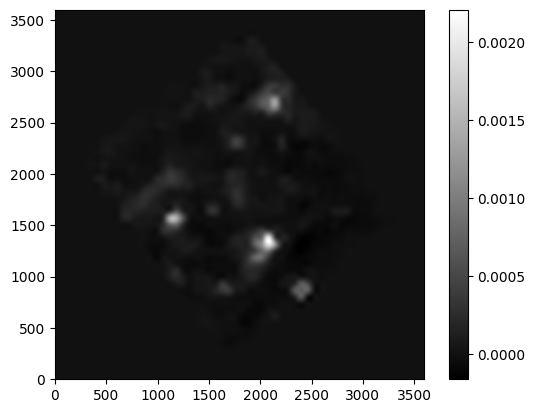

In [7]:
#show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [9]:
#background 2-d array(size of original image)
bkg_rms = bkg.rms()

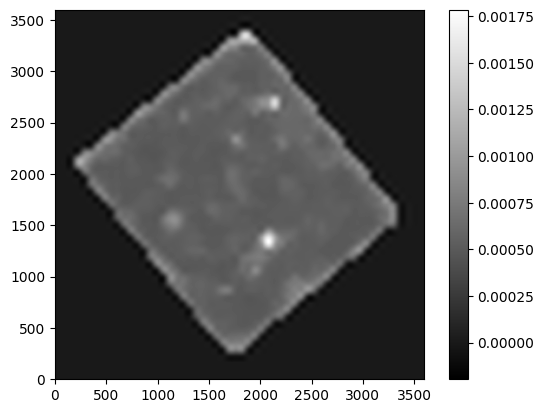

In [10]:
#show background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [11]:
#subtract the background
f105w_sub = f105w - bkg

### Number of sources detected

In [19]:
objects = sep.extract(f105w_sub, 1.5, err=bkg.globalrms)

#how many objects were detected
print(f" This many objects were detected: {len(objects)}")

 This many objects were detected: 8643


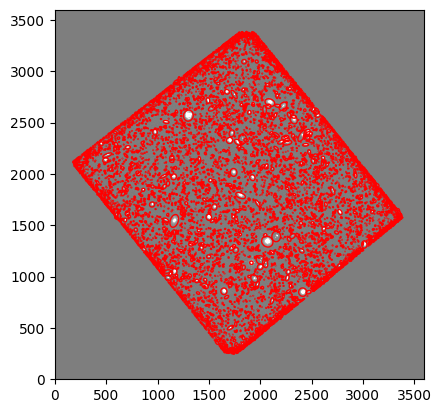

In [13]:
from matplotlib.patches import Ellipse

#background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(f105w_sub), np.std(f105w_sub)
im = ax.imshow(f105w_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [14]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [22]:
flux_f105w, fluxerr_f105w, flag_f105w = sep.sum_circle(f105w_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [23]:
#first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux_f105w[i], fluxerr_f105w[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


### Histogram the Flux

/tmp/ipykernel_210665/2664696352.py:1: RuntimeWarning: invalid value encountered in log10
  m_f105w = -2.5*np.log10(flux_f105w)


Text(0, 0.5, 'N')

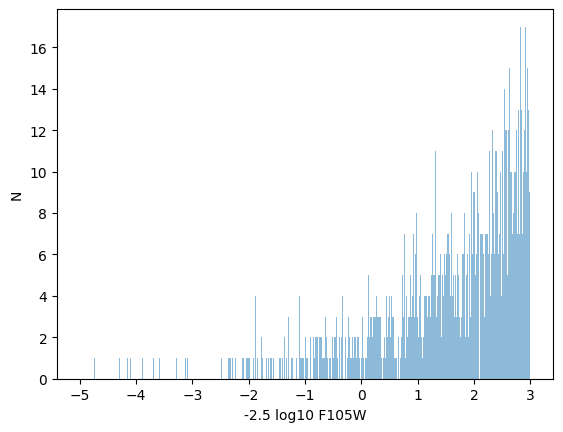

In [24]:
m_f105w = -2.5*np.log10(flux_f105w)
plt.hist(m_f105w,range=[-5,3],bins=1000,alpha=0.5)
plt.xlabel('-2.5 log10 F105W')
plt.ylabel('N')

### Mean, median, and Standard deviation of flux

In [27]:
fluxes_f105w = objects['flux']

mean_flux = np.mean(fluxes_f105w)
median_flux = np.median(fluxes_f105w)
std_flux = np.std(fluxes_f105w)

print(f"Mean flux: {mean_flux}")
print(f"Median flux: {median_flux}")
print(f"Standard deviation of flux: {std_flux}")

Mean flux: 1.17227448026878
Median flux: 0.0347491130232811
Standard deviation of flux: 17.542063555658334


### Largest Outlier

In [29]:
#largest outlier
outlier_l = np.argmax(fluxes_f105w)
outlier_flux = fluxes_f105w[outlier_l]

#how many SD the outlier is from the mean
outlier_std = (outlier_flux - mean_flux) / std_flux

print(f"Largest outlier flux: {outlier_flux}")
print(f"Outlier is {outlier_std} standard deviations away from the mean.")

Largest outlier flux: 1218.4114990234375
Outlier is 69.38973973506889 standard deviations away from the mean.


### Coordinates of Largest Outlier

The largest outlier is located at coordinates: (1914.2549094883857, 1134.3164850742164)


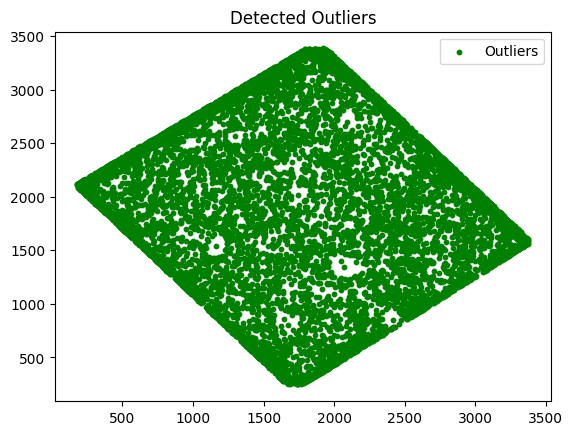

In [41]:
outlier_x = objects[outlier_l]['x']
outlier_y = objects[outlier_l]['y']

#plot outliers
plt.scatter(objects['x'], objects['y'], color='green', s=10, label="Outliers")
plt.legend()

plt.title("Detected Outliers")

print(f"The largest outlier is located at coordinates: ({outlier_x}, {outlier_y})")

### Create a 3-Color False Image RGB

##### (Repeat steps to subtract background for 2 new images)

In [57]:
f125w = fits.getdata('hubble_f125w.fits')
f160w = fits.getdata('hubble_f160w.fits')

In [58]:
median_f125w = np.nanmedian(f125w[f125w<1])
median_f444w = np.nanmedian(f160w[f160w<1])

In [59]:
f125w = f125w.byteswap().newbyteorder()
f160w = f160w.byteswap().newbyteorder()

In [60]:
bkg_f125w = sep.Background(f125w)
bkg_f160w = sep.Background(f160w)

In [62]:
f125w -= bkg_f125w
f160w -= bkg_f160w

### Rescale data

In [65]:
def rescale_data(data, dmin=0.01,dmax = 10.0):
    datac = np.clip(data,dmin,dmax)
    return (np.log10(datac)-np.log10(dmin))/(np.log10(dmax)-np.log10(dmin))

In [66]:
p_f105w = rescale_data(f105w)
p_f125w = rescale_data(f125w)
p_f160w = rescale_data(f160w)

### RGB stack of Data

In [67]:
rgb = np.stack([p_f105w,0.7*p_f125w,p_f160w],axis=-1)
print(rgb.shape)

(3600, 3600, 3)


[W 2024-12-03 20:18:24,860.860 matplotlib.image] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


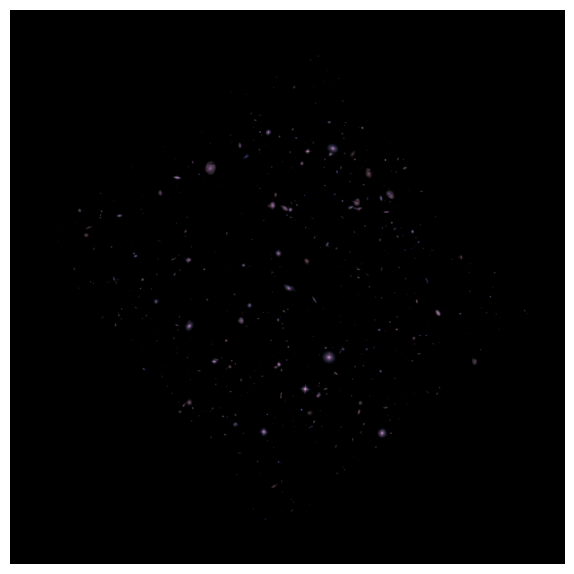

In [75]:
xsize =rgb.shape[1]
ysize =rgb.shape[0]

f,ax = plt.subplots(1,1,figsize=(xsize/500.0,ysize/500.0))
ax.axis('off')
ax.imshow(rgb,origin='lower')